In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from configparser import ConfigParser
import pathlib as pl
from itertools import combinations

import joblib as jl
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from webcolors import name_to_hex

from src.data.rasters import load_site_formated_raster
from src.root_path import config_path, root_path
from src.utils.subsets import good_sites
from src.metrics.simple_diff import ctx_effects_as_DF

from src.models.decoder import unfold_rep_ctx_prb, get_svm_accuracy, decode_and_plot
from src.data.diagonalization import diag_and_scale, load_site_dense_raster
from src.visualization.palette import add_opacity, Grey, FOURCOLOR, TENCOLOR
from src.metrics.consolidated_tstat import tstat_cluster_mass
from src.metrics.summaryDF import create_summary_DF

from src.visualization.interactive import plot_site_coverages, plot_raw_pair_array, plot_cell_coverage, plot_eg_diag, plot_raw_pair

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

figfolder = root_path / 'reports' / 'figures' / 'paper'
figfolder.mkdir(parents=True, exist_ok=True)

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2023-04-18 164730.log


cannot connect to database, loading hardcoded sites
cannot connect to database, loading hardcoded cells. TODO!


# purpose
after a first exploration of alternatives for densifying the naturally sparse contextual effects, we have simply
forced the response of all neurons to be equal for any given context (once the probe effect is subtracted),
while at the same time preserving the total response across all neurons.

For example, in a system of 2 neurons, x and y,
their original response to the context i are different: xi != yi and
xi + yi = A, where A is the total activity level.

After the densification, the modified responses are equal and the total
activity is preserved: xi == yi == A/2

xi == yi defines a diagonal, thus we name this specific approach of densification a **diagonalization**


this notebook presents a refactoring and functionalization of the diagoalization procedure, so we can apply it across
all the sites in our dataset


In [3]:
# Kinda baseline minimal parameterse
raster_meta = {'reliability': 0.1,  # r value
               'smoothing_window': 0,  # ms
               'raster_fs': 20,
               'zscore': True,
               'stim_type': 'permutations'}

# example from figure 1?
eg_cellid, eg_ctx_pair, eg_prb = 'ARM021b-36-8', [0,1], 3 # example from figure 2, with nice PSTHs
# eg_cellid, eg_ctx_pair, eg_prb = 'ARM017a-39-2', [0,1], 3
eg_site = eg_cellid.split('-')[0]

# load cache of sigle cell rasters for this example site
if load_site_formated_raster.check_call_in_cache(eg_site, **raster_meta):
    raster, cellids = load_site_formated_raster(eg_site, **raster_meta)
    print(f'####\n'
          f'found and loaded cache for {eg_site}')
else:
    print(f"cant load load_site_formated_raster with {raster_meta}.\n this should be cached, why is it failing? ")


# small data subset with 2 neurons, 1 probe, and 1 timepoint, usefull for development and debuging
test_raster = raster[:,np.asarray([19,21]),...][...,0,0][:,:,:,None,None] # 2 neurons, 1 probe, 1 time point

####
found and loaded cache for ARM021b


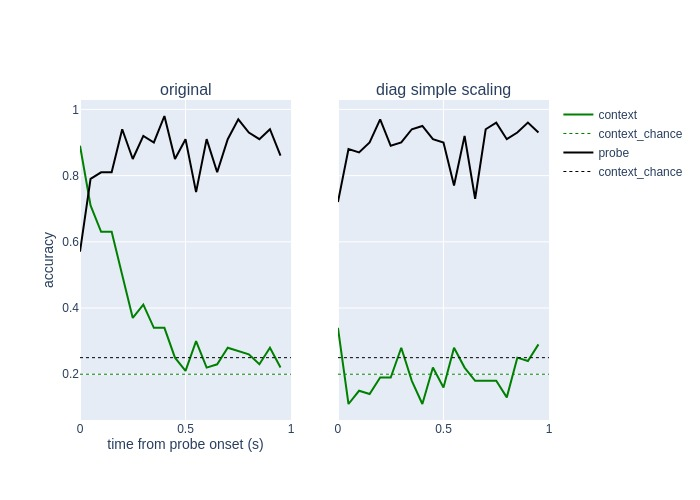

In [4]:
diag_simple_scaling = diag_and_scale(raster, mode='mean_var')

fig = make_subplots(rows=1, cols=2, shared_yaxes='all', shared_xaxes='all',
                    subplot_titles=['original', 'diag simple scaling'])

for cc, arr in enumerate([raster, diag_simple_scaling]):
    showlegend = True if cc == 0 else False
    f, _, _ = decode_and_plot(arr,showlegend=showlegend)
    f = f['data']
    fig.add_traces(f, rows=[1]*len(f), cols=[cc+1]*len(f))

_ = fig.update_xaxes(title_text='time from probe onset (s)', title_standoff=0, row=1, col=1)
_ = fig.update_yaxes(title_text='accuracy', title_standoff=0, row=1, col=1)

fig.show(renderer='jpeg')

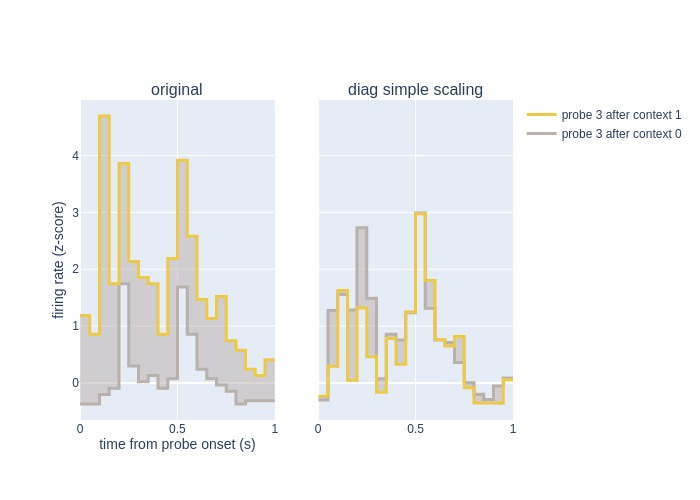

In [5]:
fig = make_subplots(rows=1, cols=2, shared_yaxes='all', shared_xaxes='all',
                    subplot_titles=['original', 'diag simple scaling'])


for cc, arr in enumerate([raster, diag_simple_scaling]):
    showlegend = True if cc == 0 else False
    f = plot_raw_pair_array(arr, cellids, eg_cellid, eg_ctx_pair, eg_prb, raster_meta['raster_fs'],
                    part='probe', hightlight_difference=True, CI=None, showlegend=showlegend,
                            color_palette=FOURCOLOR)['data']
    fig.add_traces(f, rows=[1]*len(f), cols=[cc+1]*len(f))

_ = fig.update_xaxes(title_text='time from probe onset (s)', title_standoff=0, row=1, col=1)
_ = fig.update_yaxes(title_text='firing rate (z-score)', title_standoff=0, row=1, col=1)

fig.show(renderer='jpeg')

# better coverage
the idea being to calculate the same cluster mass t-score integral metrics for the diagonalized data,
such that it can be directly compared with the coverages of the same neurons in the original data.
The T-score cluster mass is quite compute intesive due to the motecarlo, however, we just need the one example site

for that purpose extend the traditional pipeline of caltulating and cacheing tstats and recopilating them in dataframes

In [6]:
montecarlo = 11000
cluster_threshold = 0.05
loading_func = 'dense'
# loading_func = 'SC'
_ = tstat_cluster_mass(eg_site, cluster_threshold=cluster_threshold, montecarlo=montecarlo,
                         raster_meta=raster_meta, load_fn=loading_func)

# which one do i need??
multiple_corrections = {
    'bf_cp': [1, 2], # vanila boferroni for contexts and probes
    # 'bf_ncp': [0, 1, 2] # more strict bonferroni also considering neurons, for union
}

dense_eg_DF_file = pl.Path(config['paths']['analysis_cache']) / f'230220_dense_eg_DF'
create_summary_DF([eg_site], [loading_func, "SC"], [cluster_threshold], 0.05, montecarlo, raster_meta,
                  ['integral_no_abs', 'integral'], ['real'],
                  multiple_corrections, dense_eg_DF_file, ['delta_FR'], keep_pvalues=False, recacheDF=True)

dense_eg_DF = jl.load(dense_eg_DF_file)

all sites: 
['ARM021b']



100%|██████████| 2/2 [00:00<00:00, 30.27it/s]

             id context_pair probe      value           metric mult_comp_corr  \
0  ARM021b-02-2        00_01     1  97.238426  integral_no_abs          bf_cp   
1  ARM021b-04-3        00_01     1  97.238426  integral_no_abs          bf_cp   
2  ARM021b-05-1        00_01     1   0.000000  integral_no_abs          bf_cp   
3  ARM021b-05-2        00_01     1  97.238426  integral_no_abs          bf_cp   
4  ARM021b-06-3        00_01     1   0.690950  integral_no_abs          bf_cp   
5  ARM021b-06-4        00_01     1 -23.204546  integral_no_abs          bf_cp   
6  ARM021b-10-4        00_01     1  64.701530  integral_no_abs          bf_cp   
7  ARM021b-12-7        00_01     1  47.381004  integral_no_abs          bf_cp   
8  ARM021b-16-7        00_01     1  42.706429  integral_no_abs          bf_cp   
9  ARM021b-19-4        00_01     1  22.413334  integral_no_abs          bf_cp   

  analysis diff_metric     site region source cluster_threshold stim_count  
0    dense    delta_FR  ARM021b

['ARM021b-02-2', 'ARM021b-04-3', 'ARM021b-05-1', 'ARM021b-05-2', 'ARM021b-06-3', ..., 'ARM021b-51-4', 'ARM021b-52-4', 'ARM021b-52-5', 'ARM021b-52-6', 'ARM021b-53-1']
Length: 33
Categories (33, object): ['ARM021b-02-2', 'ARM021b-04-3', 'ARM021b-05-1', 'ARM021b-05-2', ..., 'ARM021b-52-4', 'ARM021b-52-5', 'ARM021b-52-6', 'ARM021b-53-1']


/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered

/home/mateo/code/context_probe_analysis/src/visualization/interactive.py:1294: RuntimeWarning:

All-NaN axis encountered



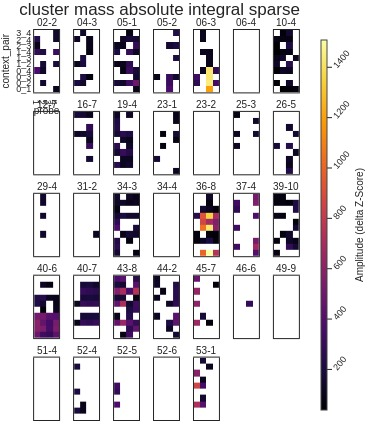

['ARM021b-02-2', 'ARM021b-04-3', 'ARM021b-05-1', 'ARM021b-05-2', 'ARM021b-06-3', ..., 'ARM021b-51-4', 'ARM021b-52-4', 'ARM021b-52-5', 'ARM021b-52-6', 'ARM021b-53-1']
Length: 33
Categories (33, object): ['ARM021b-02-2', 'ARM021b-04-3', 'ARM021b-05-1', 'ARM021b-05-2', ..., 'ARM021b-52-4', 'ARM021b-52-5', 'ARM021b-52-6', 'ARM021b-53-1']


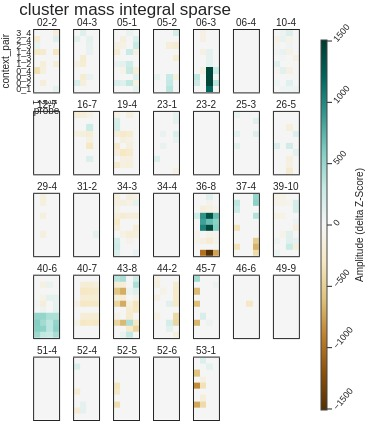

In [7]:
fig = plot_site_coverages(dense_eg_DF.query("metric == 'integral' and analysis == 'SC'"))
fig.update_layout(title_text= 'cluster mass absolute integral sparse')
fig.show(renderer='jpeg', scale=1)

fig = plot_site_coverages(dense_eg_DF.query("metric == 'integral_no_abs' and analysis == 'SC'"), has_neg=True)
fig.update_layout(title_text= 'cluster mass integral sparse')
fig.show(renderer='jpeg', scale=1)

['ARM021b-02-2', 'ARM021b-04-3', 'ARM021b-05-1', 'ARM021b-05-2', 'ARM021b-06-3', ..., 'ARM021b-51-4', 'ARM021b-52-4', 'ARM021b-52-5', 'ARM021b-52-6', 'ARM021b-53-1']
Length: 33
Categories (33, object): ['ARM021b-02-2', 'ARM021b-04-3', 'ARM021b-05-1', 'ARM021b-05-2', ..., 'ARM021b-52-4', 'ARM021b-52-5', 'ARM021b-52-6', 'ARM021b-53-1']


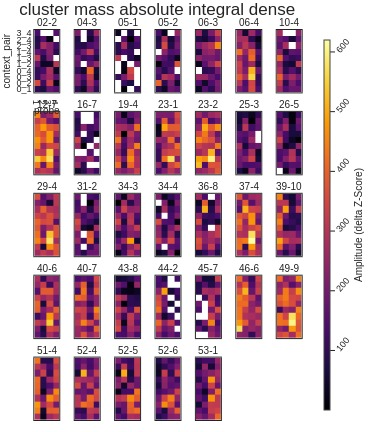

['ARM021b-02-2', 'ARM021b-04-3', 'ARM021b-05-1', 'ARM021b-05-2', 'ARM021b-06-3', ..., 'ARM021b-51-4', 'ARM021b-52-4', 'ARM021b-52-5', 'ARM021b-52-6', 'ARM021b-53-1']
Length: 33
Categories (33, object): ['ARM021b-02-2', 'ARM021b-04-3', 'ARM021b-05-1', 'ARM021b-05-2', ..., 'ARM021b-52-4', 'ARM021b-52-5', 'ARM021b-52-6', 'ARM021b-53-1']


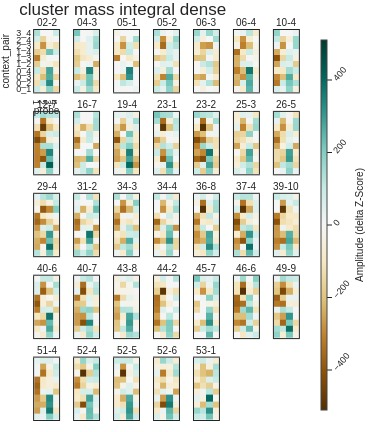

In [8]:
fig = plot_site_coverages(dense_eg_DF.query("metric == 'integral' and analysis == 'dense'"))
fig.update_layout(title_text= 'cluster mass absolute integral dense')
fig.show(renderer='jpeg', scale=1)

fig = plot_site_coverages(dense_eg_DF.query("metric == 'integral_no_abs' and analysis == 'dense'"), has_neg=True)
fig.update_layout(title_text= 'cluster mass integral dense')
fig.show(renderer='jpeg', scale=1)

['ARM021b-02-2' 'ARM021b-04-3' 'ARM021b-05-1' 'ARM021b-05-2'
 'ARM021b-06-3' 'ARM021b-06-4' 'ARM021b-10-4' 'ARM021b-12-7'
 'ARM021b-16-7' 'ARM021b-19-4' 'ARM021b-23-1' 'ARM021b-23-2'
 'ARM021b-25-3' 'ARM021b-26-5' 'ARM021b-29-4' 'ARM021b-31-2'
 'ARM021b-34-3' 'ARM021b-34-4' 'ARM021b-36-8' 'ARM021b-37-4'
 'ARM021b-39-10' 'ARM021b-40-6' 'ARM021b-40-7' 'ARM021b-43-8'
 'ARM021b-44-2' 'ARM021b-45-7' 'ARM021b-46-6' 'ARM021b-49-9'
 'ARM021b-51-4' 'ARM021b-52-4' 'ARM021b-52-5' 'ARM021b-52-6'
 'ARM021b-53-1']


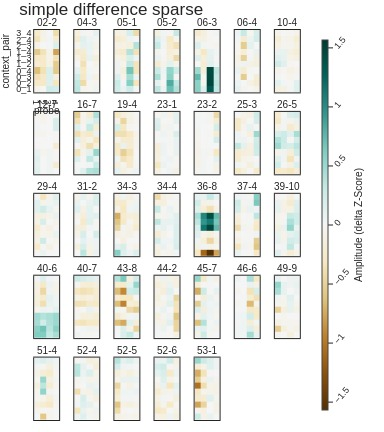

['ARM021b-02-2' 'ARM021b-04-3' 'ARM021b-05-1' 'ARM021b-05-2'
 'ARM021b-06-3' 'ARM021b-06-4' 'ARM021b-10-4' 'ARM021b-12-7'
 'ARM021b-16-7' 'ARM021b-19-4' 'ARM021b-23-1' 'ARM021b-23-2'
 'ARM021b-25-3' 'ARM021b-26-5' 'ARM021b-29-4' 'ARM021b-31-2'
 'ARM021b-34-3' 'ARM021b-34-4' 'ARM021b-36-8' 'ARM021b-37-4'
 'ARM021b-39-10' 'ARM021b-40-6' 'ARM021b-40-7' 'ARM021b-43-8'
 'ARM021b-44-2' 'ARM021b-45-7' 'ARM021b-46-6' 'ARM021b-49-9'
 'ARM021b-51-4' 'ARM021b-52-4' 'ARM021b-52-5' 'ARM021b-52-6'
 'ARM021b-53-1']


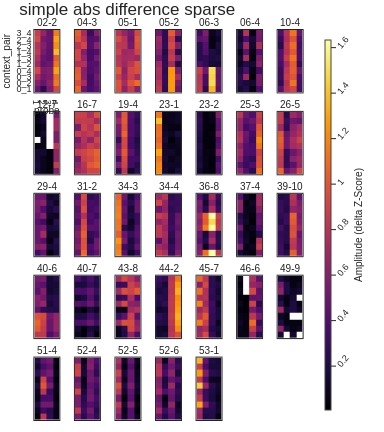

In [9]:
dense_DF = ctx_effects_as_DF(raster, cellids, raster_meta['raster_fs'], abs=False).query("chunk == 'Full'")
fig = plot_site_coverages(dense_DF, has_neg=True)
fig.update_layout(title_text='simple difference sparse')
fig.show(renderer='jpeg', scale=1)

dense_DF = ctx_effects_as_DF(raster, cellids, raster_meta['raster_fs'], abs=True).query("chunk == 'Full'")
fig = plot_site_coverages(dense_DF, has_neg=False)
fig.update_layout(title_text='simple abs difference sparse')
fig.show(renderer='jpeg', scale=1)

['ARM021b-02-2' 'ARM021b-04-3' 'ARM021b-05-1' 'ARM021b-05-2'
 'ARM021b-06-3' 'ARM021b-06-4' 'ARM021b-10-4' 'ARM021b-12-7'
 'ARM021b-16-7' 'ARM021b-19-4' 'ARM021b-23-1' 'ARM021b-23-2'
 'ARM021b-25-3' 'ARM021b-26-5' 'ARM021b-29-4' 'ARM021b-31-2'
 'ARM021b-34-3' 'ARM021b-34-4' 'ARM021b-36-8' 'ARM021b-37-4'
 'ARM021b-39-10' 'ARM021b-40-6' 'ARM021b-40-7' 'ARM021b-43-8'
 'ARM021b-44-2' 'ARM021b-45-7' 'ARM021b-46-6' 'ARM021b-49-9'
 'ARM021b-51-4' 'ARM021b-52-4' 'ARM021b-52-5' 'ARM021b-52-6'
 'ARM021b-53-1']


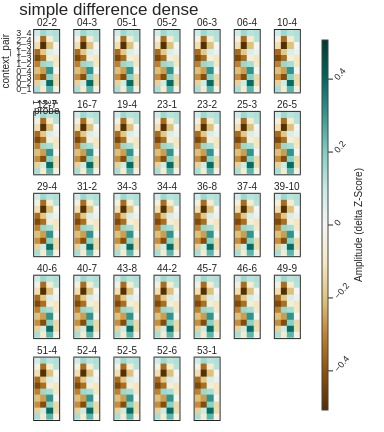

['ARM021b-02-2' 'ARM021b-04-3' 'ARM021b-05-1' 'ARM021b-05-2'
 'ARM021b-06-3' 'ARM021b-06-4' 'ARM021b-10-4' 'ARM021b-12-7'
 'ARM021b-16-7' 'ARM021b-19-4' 'ARM021b-23-1' 'ARM021b-23-2'
 'ARM021b-25-3' 'ARM021b-26-5' 'ARM021b-29-4' 'ARM021b-31-2'
 'ARM021b-34-3' 'ARM021b-34-4' 'ARM021b-36-8' 'ARM021b-37-4'
 'ARM021b-39-10' 'ARM021b-40-6' 'ARM021b-40-7' 'ARM021b-43-8'
 'ARM021b-44-2' 'ARM021b-45-7' 'ARM021b-46-6' 'ARM021b-49-9'
 'ARM021b-51-4' 'ARM021b-52-4' 'ARM021b-52-5' 'ARM021b-52-6'
 'ARM021b-53-1']


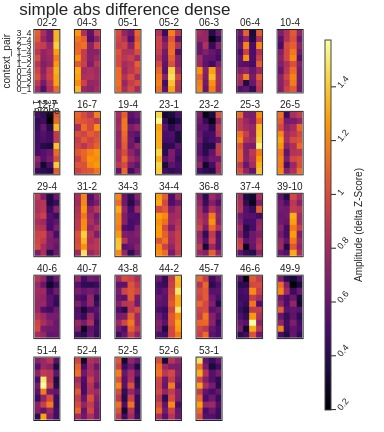

In [10]:
dense_raster,_ = load_site_dense_raster(eg_site, **raster_meta)

dense_DF = ctx_effects_as_DF(dense_raster, cellids, raster_meta['raster_fs'], abs=False).query("chunk == 'Full'")
fig = plot_site_coverages(dense_DF, has_neg=True)
fig.update_layout(title_text='simple difference dense')
fig.show(renderer='jpeg', scale=1)

dense_DF = ctx_effects_as_DF(dense_raster, cellids, raster_meta['raster_fs'], abs=True).query("chunk == 'Full'")
fig = plot_site_coverages(dense_DF, has_neg=False)
fig.update_layout(title_text='simple abs difference dense')
fig.show(renderer='jpeg', scale=1)

### well problems
it seems that the random variation between neurons and the nonlinearity of absolute value
is enought that the cluster mass analysis finds differences between neurons. Just to check below is the contex effect as simple differences

#### select an example
bite the bullet and work with the simple and just chose 2 neurons 2 probes and 3 contexts
to display in the diagonalization example. we want the instance to be as different
as possible between them and between neurons.
looking



In [11]:
# # lets try to find the most diving and hopefully differente probes, independente of contexte
# from src.visualization.utils import square_rows_cols, squarefy
#
# prb_psths = raster.mean(axis=(0,2))
# chn, prb, tme = prb_psths.shape
# t = np.linspace(0, 1, tme, endpoint=False)
# rows, cols = square_rows_cols(chn)
#
# fig = make_subplots(rows, cols, shared_xaxes='all', shared_yaxes='all',
#                     horizontal_spacing=0.01,vertical_spacing=0.05,
#                     subplot_titles=cellids)
#
# for cid, cellid in enumerate(cellids):
#     showlegend = True if cid == 0 else False
#
#     row, col = int(np.floor(cid / cols)+1), (cid % cols) + 1
#     for pp in range(prb):
#         y = prb_psths[cid,pp,:]
#         tt, yy = squarefy(t, y)
#         fig.add_trace(go.Scatter(x=tt, y=yy, mode='lines', line_color=FOURCOLOR[pp+1],
#                                  name=f'prb_{pp+1}', showlegend=showlegend),
#                       row=row, col=col)
#
# fig.update_layout(height=10*96, width=15*96)
# fig.show(renderer='jpeg')

['ARM021b-36-8' 'ARM021b-43-8' 'dense']


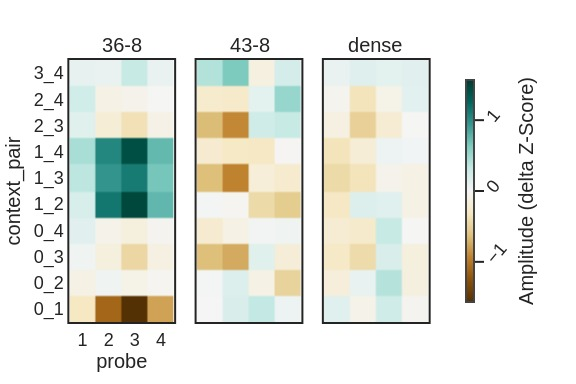

In [12]:
# good looking examples... i hope.
eg_neurons = ["ARM021b-" + ci for ci in ['36-8', '43-8']] # original order
eg_neurons = ["ARM021b-" + ci for ci in ['43-8', '36-8']] # inverted order for vertical layout
eg_probes = [3,4]
# eg_ctxs = [0,1,2,3,4]
eg_ctxs = [1,2,3]
eg_ctx_pairs = list(combinations(eg_ctxs, 2))

eg_times = [5] # empirically determined late ron


sparse_df = ctx_effects_as_DF(raster, cellids, raster_meta['raster_fs'], abs=False
                              ).query(f"chunk == 'Full' and id in {eg_neurons}") # simple diff
# hack appende dense converage

dense_df = ctx_effects_as_DF(dense_raster, cellids, raster_meta['raster_fs'], abs=False
                             ).query(f"chunk == 'Full' and id == '{eg_neurons[0]}'")
dense_df['id'] = 'dense'

toplot_df =  pd.concat((sparse_df, dense_df))

fig = plot_site_coverages(toplot_df, has_neg=True)
fig.update_layout(height=96*2, width=96*3)

filename = figfolder / 'fig3_dense_coverages'
# fig.write_image(filename.with_suffix('.png'), scale=2)
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

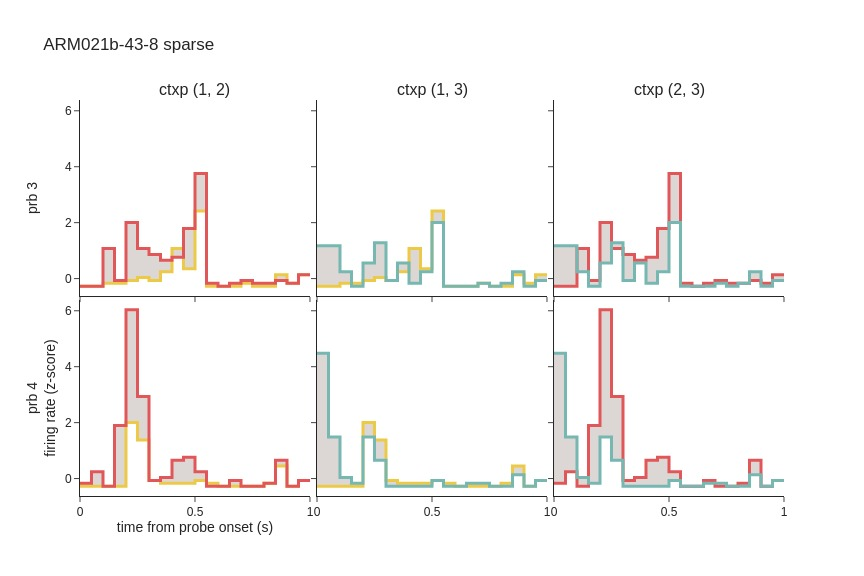

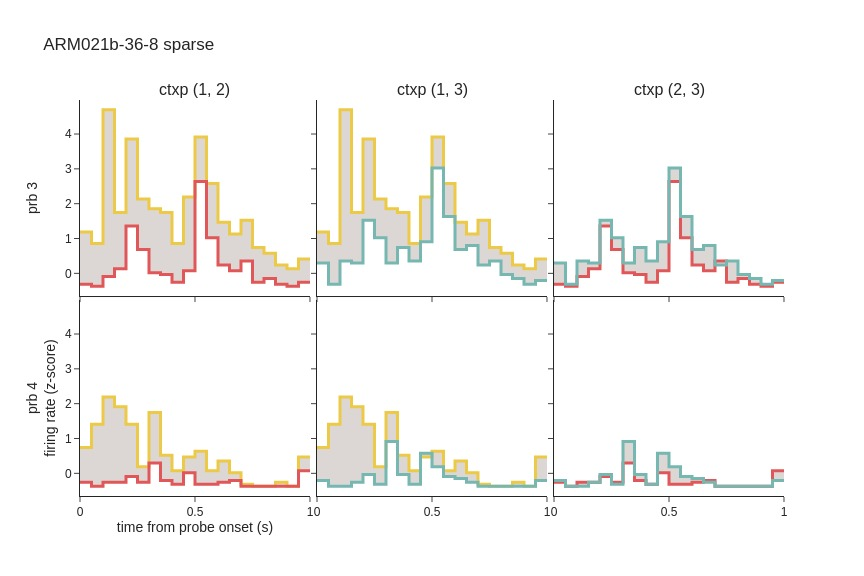

In [13]:
n_rows, n_cols = len(eg_probes), len(eg_ctx_pairs)
for eg_cellid in eg_neurons:
    fig = make_subplots(rows=n_rows, cols=n_cols, shared_yaxes='all', shared_xaxes='all',
                        vertical_spacing=0.01, horizontal_spacing=0.01,
                        subplot_titles=[f"ctxp {cp}" for cp in eg_ctx_pairs])

    for rr, eg_prb in enumerate(eg_probes):
        for cc, eg_ctx_pair in enumerate(eg_ctx_pairs):
            # showlegend = True if cc == 0 else False
            f = plot_raw_pair_array(raster, cellids, eg_cellid, eg_ctx_pair, eg_prb, raster_meta['raster_fs'],
                                    part='probe', hightlight_difference=True, CI=None, showlegend=showlegend)['data']
            fig.add_traces(f, rows=[rr+1] * len(f), cols=[cc + 1] * len(f))

        _ = fig.update_yaxes(title_text=f'prb {eg_probes[rr]}<br> ', title_standoff=0, row=rr+1, col=1)
    _ = fig.update_layout(title_text=f"{eg_cellid} sparse")
    _ = fig.update_xaxes(title_text='time from probe onset (s)', title_standoff=0, row=n_rows, col=1)
    _ = fig.update_yaxes(title_text=f'prb {eg_probes[-1]}<br>firing rate (z-score)', title_standoff=0, row=n_rows, col=1)
    fig.update_layout(template='simple_white',height=6*96, width=9*96)

    fig.show(renderer='jpeg')


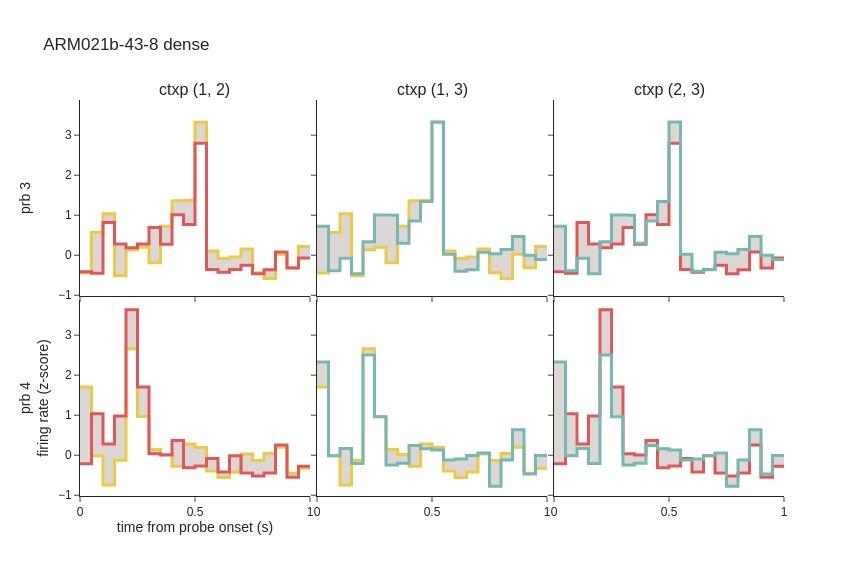

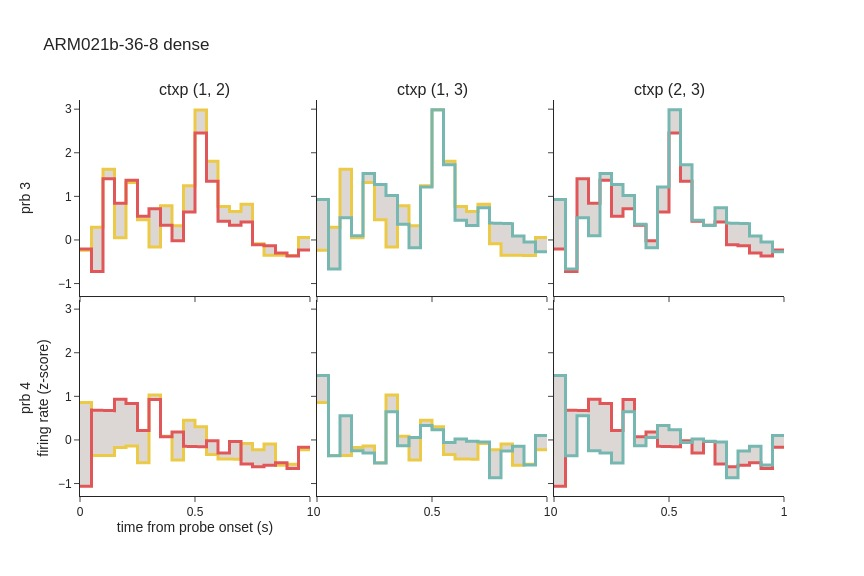

In [14]:
n_rows, n_cols = len(eg_probes), len(eg_ctx_pairs)
for eg_cellid in eg_neurons:
    fig = make_subplots(rows=n_rows, cols=n_cols, shared_yaxes='all', shared_xaxes='all',
                        vertical_spacing=0.01, horizontal_spacing=0.01,
                        subplot_titles=[f"ctxp {cp}" for cp in eg_ctx_pairs])

    for rr, eg_prb in enumerate(eg_probes):
        for cc, eg_ctx_pair in enumerate(eg_ctx_pairs):
            # showlegend = True if cc == 0 else False
            f = plot_raw_pair_array(dense_raster, cellids, eg_cellid, eg_ctx_pair, eg_prb, raster_meta['raster_fs'],
                                    part='probe', hightlight_difference=True, CI=None, showlegend=showlegend)['data']
            fig.add_traces(f, rows=[rr+1] * len(f), cols=[cc + 1] * len(f))

        _ = fig.update_yaxes(title_text=f'prb {eg_probes[rr]}<br> ', title_standoff=0, row=rr+1, col=1)
    _ = fig.update_layout(title_text=f"{eg_cellid} dense")
    _ = fig.update_xaxes(title_text='time from probe onset (s)', title_standoff=0, row=n_rows, col=1)
    _ = fig.update_yaxes(title_text=f'prb {eg_probes[-1]}<br>firing rate (z-score)', title_standoff=0, row=n_rows, col=1)
    fig.update_layout(template='simple_white',height=6*96, width=9*96)

    fig.show(renderer='jpeg')


## simple PSTHs
to compress the information of the pairwise comparisons for two neurons and with sparse and dense, we can just consider
the PSHT of all compared instances together. Furthermore, we can also plot the probe PHSTs , i.e., the context average.
This is useful insofar as it shows that the overal probe PSTH does not change during densification, only the individual
instances

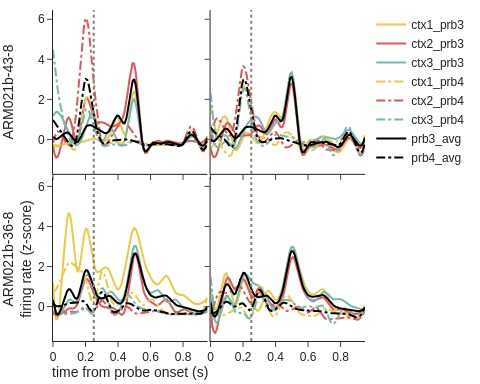

In [15]:
# try to compress all inte information about a single neuron in a single pannel
from src.visualization.utils import squarefy, square_rows_cols
from scipy.interpolate import make_interp_spline, BSpline

def simple_psths(fnArrs: list[np.array],
                 cellids: list[str],
                 cells: list[str],
                 contexts: list[int],
                 probes: list[int],
                 color_palette: list[str] = FOURCOLOR) -> go.Figure:
    cidxs = [cellids.index(c) for c in cells]
    prbidxs = [p - 1 for p in probes]

    PSTHs = [a.mean(axis=0) for a in fnArrs]
    chn, ctx, prb, tme = PSTHs[0].shape
    t = np.linspace(0, 1, tme, endpoint=False)

    dashings = ['dot', 'dash', 'solid', 'dashdot']

    # rows, cols = square_rows_cols(len(cellid))
    fig = make_subplots(len(cells), len(fnArrs), shared_xaxes='all', shared_yaxes='all',
                        vertical_spacing=0.01, horizontal_spacing=0.01)

    pan = 0
    for col, psth in enumerate(PSTHs):
        for row, cidx in enumerate(cidxs):
            # row, col = int(np.floor(cc / cols)) + 1, (cc % cols) + 1
            showlegend = True if pan == 0 else False
            pan = + 1

            # individual context probe lines
            for prbidx in prbidxs:
                dash = dashings[prbidx]

                for ctxidx in contexts:
                    color = color_palette[ctxidx]
                    y = psth[cidx, ctxidx, prbidx, :]
                    # tt, yy = squarefy(t, y)
                    # tt, yy = t, y
                    tt = np.linspace(t.min(), t.max(), 100)
                    yy = make_interp_spline(t, y, k=3)(tt)

                    fig.add_trace(go.Scatter(x=tt, y=yy, mode='lines', line=dict(color=color, dash=dash, width=2),
                                             name=f"ctx{ctxidx}_prb{prbidx + 1}", showlegend=showlegend),
                                  row=row + 1, col=col + 1)

            # probe PSTH, all contexts averaged
            # in new for loop to ensure averages are on top of instace lines
            for prbidx in prbidxs:
                dash = dashings[prbidx]

                y = psth[cidx, :, prbidx, :].mean(axis=0)
                # tt, yy = squarefy(t, y)
                # tt, yy = t, y
                tt = np.linspace(t.min(), t.max(), 100)
                yy = make_interp_spline(t, y, k=3)(tt)
                fig.add_trace(go.Scatter(x=tt, y=yy, mode='lines', line=dict(color='black', dash=dash, width=2),
                                         name=f"prb{prbidx + 1}_avg", showlegend=showlegend),
                              row=row + 1, col=col + 1)

            # add neuron name on left column
            if col == 0:
                # skips last row since its treated differently
                if row < len(cells) -1:
                    _ = fig.update_yaxes(title_text=f'{cells[row]}<br> ', title_standoff=0,
                         row=row+1, col=1)


    _ = fig.update_xaxes(title_text='time from probe onset (s)', title_standoff=0,
                         row=len(cells), col=1)
    _ = fig.update_yaxes(title_text=f'{cells[-1]}<br>firing rate (z-score)', title_standoff=0,
                         row=len(fnArrs), col=1)

    fig.update_layout(template='simple_white',
                      margin=dict(b=10, l=10, r=10, t=10))

    return fig


fig = simple_psths([raster, dense_raster], cellids, eg_neurons, eg_ctxs, eg_probes)

fig.add_vline(eg_times[0]*1/20, line_color='gray', line_dash='dot', line_width=2, opacity=1)
fig.update_layout(height=96*4, width=96*5)

filename = figfolder / 'fig3_dense_psths'
# fig.write_image(filename.with_suffix('.png'), scale=2)
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=1)

#### select a time point
time point 2 seems to have a lot of interesing changes between the neurons.
lets plot the 2 neuron state space for those 2 probes, 3 context and one time point

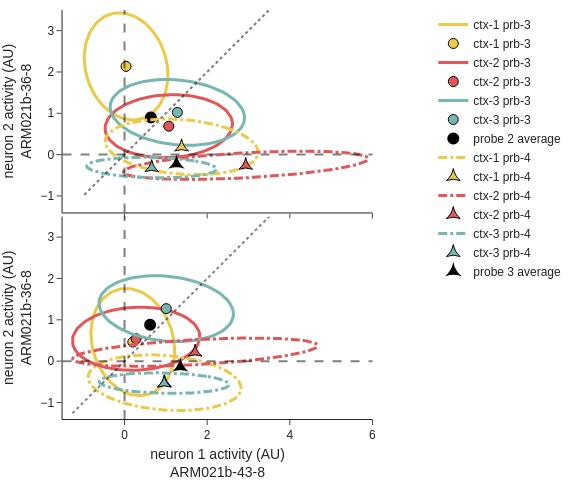

In [16]:
rep, chn, ctx, prb, tme = raster.shape
# smart index to select all reps for 2 neurons, all contexts, two probes and one time point
idxr = np.ix_(np.arange(rep),
              [cellids.index(cid) for cid in eg_neurons],
              eg_ctxs,
              np.asarray(eg_probes)-1,
              eg_times)

fig = plot_eg_diag([raster, dense_raster],
                   idxr,trial_mode='ellipse', n_std=1, jitter=0.3,
                   orientation='v')

fig.update_layout(height=96*5, width=96*6,
                  margin=dict(l=10, r=10, t=10, b=10),
                  showlegend=True)

# axis labels
_ = fig.update_xaxes(title=dict(text=f'neuron 1 activity (AU)<br>{eg_neurons[0]}', standoff=0),
                     row=2, col=1)
_ = fig.update_yaxes(title=dict(text=f'neuron 2 activity (AU)<br>{eg_neurons[1]}', standoff=0))
fig.update_xaxes(constrain='domain', range=[-1.5, 6])
fig.update_yaxes(constrain='domain', range=[-1.4, 3.5])


filename = figfolder / 'fig3_dense_scatter'
# fig.write_image(filename.with_suffix('.png'), scale=2)
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=1)


# All sites

same pipeline for all sites

In [17]:
# quick cache
acc_df_file = pl.Path(config['paths']['analysis_cache']) / f'230220_SC_decoder_accuracies'

recache_acc = False

if acc_df_file.exists() and not recache_acc:
    print('DF cache found, reloading')
    accuracy_df = jl.load(acc_df_file)

elif (not acc_df_file.exists()) or recache_acc:
    print('creating DF of site decoder accuracies ...')
    accuracy_df = list()
    for site in good_sites:
    # for site in [eg_site]:
        fn = load_site_formated_raster
        if fn.check_call_in_cache(site, **raster_meta):
            print(f'cache found for {site}')
            raster, _ = fn(site, **raster_meta)
        else:
            print(f"cant load {fn} with {raster_meta}.\n this should be cached, why is it failing? ")

        nsounds = raster.shape[3]
        codes = dict(sparse= raster,
                     dense = diag_and_scale(raster, mode='mean_var'))

        for code, rast in codes.items():
            unfolded, labels = unfold_rep_ctx_prb(rast)
            for part in ['context', 'probe']:
                accuracy, chance = get_svm_accuracy(unfolded, labels[part])

                d = {'site': site,
                     'code': code,
                     'part': part,
                     'accuracy': accuracy,
                     'chance': chance,
                     'nsounds': nsounds}

                accuracy_df.append(d)

    accuracy_df = pd.DataFrame(accuracy_df)
    print('... done creating DF')

    jl.dump(accuracy_df, acc_df_file)

DF cache found, reloading


### plots the cumulative data
lets see how the decoder analysis performs for all sites in their starting sparse encoding, and then once transformed
to the different dense codes

In [18]:

part = 'context'
code = 'sparse'
nsounds = 4

def plot_acc_from_df(fnDF, part, code, nsounds, color='black', showlegend=False):
    fig = go.Figure()
    indf = fnDF.query(f"part=='{part}' and code=='{code}' and nsounds=={nsounds}")
    chance = indf.chance.unique()[0]
    arr = np.stack(indf.loc[:, 'accuracy'].values)

    t = np.linspace(0, 1, arr.shape[1], endpoint=True)  # hardcoded 0 to 1 timeframe, fine for now
    # individual lines, damn you plotly for this verbose monster
    print(f'{len(arr)} sites')
    for l in arr:
        fig.add_trace(
            go.Scatter(x=t, y=l, mode='lines', opacity=0.3, showlegend=False,
                       line=dict(color=add_opacity(name_to_hex(color), 0.3)),
                       )
        )

    # mean of all lines
    fig.add_trace(
            go.Scatter(x=t, y=arr.mean(axis=0), mode='lines', showlegend=showlegend,
                       line=dict(color=color), name=f'{part}_{code}'
                       )
        )

    # chance line
    fig.add_trace(
            go.Scatter(x=[t[0],t[-1]], y=[chance]*2, mode='lines', showlegend=showlegend,
                       line=dict(color=color, dash='dot'), name=f'chance={chance:.2f}'
                       )
        )

    return fig

35 sites
35 sites
28 sites
28 sites
35 sites
35 sites
28 sites
28 sites


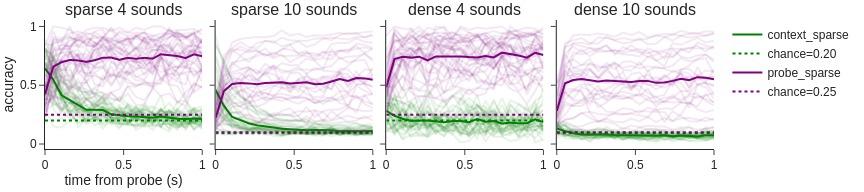

In [19]:
from itertools import product
encodings = ['sparse', 'dense']
parts = ['context', 'probe']
nsounds = [4, 10]

fig = make_subplots(rows=1, cols=4, shared_xaxes='all', shared_yaxes='all',
                    subplot_titles= [f"{e} {n} sounds" for e, n in product(encodings, nsounds)],
                    vertical_spacing=0.02, horizontal_spacing=0.02)

ii = 0
for cc, code in enumerate(encodings):
    for rr, ns in enumerate(nsounds):
        col = rr + 1 + (cc) * 2
        showlegend = True if ii == 0 else False
        ii += 1
        for part, color in zip(parts, ['green', 'purple']):
             f = plot_acc_from_df(accuracy_df, part, code, nsounds=ns, color=color, showlegend=showlegend)['data']
             fig.add_traces(f, rows=[1]*len(f), cols=[col]*len(f))


fig.update_yaxes(title=dict(text=f'accuracy', standoff=0), row=1, col=1)
fig.update_xaxes(title=dict(text='time from probe (s)', standoff=0),row=1, col=1)

fig.update_layout(height=96*2, width=96*9,
                  template='simple_white',
                  margin={'t':20, 'l':10, 'b': 10, 'r': 10})

filename = figfolder / 'fig3_decoder_accuracies'
# fig.write_image(filename.with_suffix('.png'), scale=2)
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=1)

##### Simpliffied
here I just keep the 10 sound examples and organize the vertically

28 sites
28 sites
28 sites
28 sites


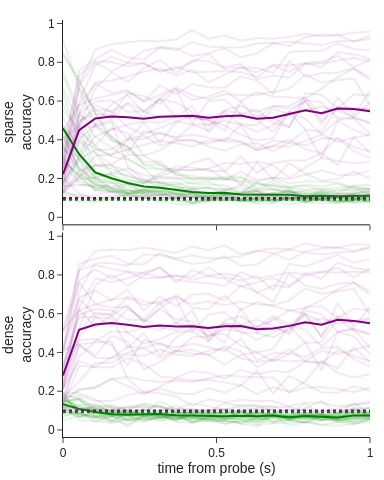

In [20]:
from itertools import product
encodings = ['sparse', 'dense']
parts = ['context', 'probe']

fig = make_subplots(rows=2, cols=1, shared_xaxes='all', shared_yaxes='all',
                    vertical_spacing=0.02, horizontal_spacing=0.02)

for cc, code in enumerate(encodings):
        showlegend = True if cc == 0 else False
        for part, color in zip(parts, ['green', 'purple']):
             f = plot_acc_from_df(accuracy_df, part, code, nsounds=10, color=color, showlegend=showlegend)['data']
             fig.add_traces(f, rows=[cc+1]*len(f), cols=[1]*len(f))


fig.update_yaxes(title=dict(text=f'sparse<br>accuracy', standoff=0), row=1, col=1)
fig.update_yaxes(title=dict(text=f'dense<br>accuracy', standoff=0), row=2, col=1)
fig.update_xaxes(title=dict(text='time from probe (s)', standoff=0),
                 row=2, col=1)

fig.update_layout(height=96*5, width=96*4,
                  template='simple_white',
                  margin={'t':20, 'l':10, 'b': 10, 'r': 10},
                  showlegend=False)

filename = figfolder / 'fig3_decoder_accuracies_simple'
# fig.write_image(filename.with_suffix('.png'), scale=2)
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=1)

In [21]:
print(2.739905e-04)
print(5.0e-02)
print(1.0e-02)
print(1.0e-03)

0.0002739905
0.05
0.01
0.001
